In [1]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
im = plt.imread("zeldaimage.jpg")

im.shape

(1080, 1920, 3)

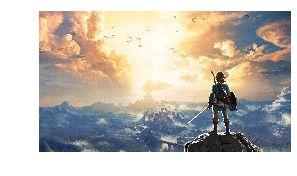

In [3]:
def plti(im, h=8, **kwargs):
    #Helper function to plot an image
    
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')
    
plti(im)

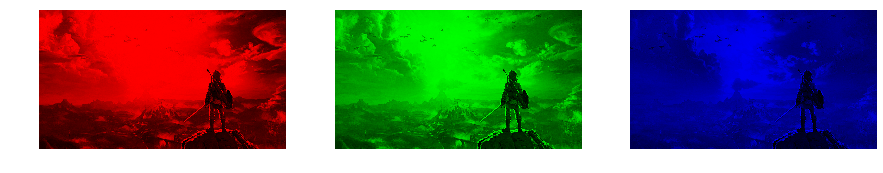

In [4]:
#Each pixel of a color image is represented by 3 integers, 
#its RGB value. Splitting the image into seperate colour components is 
#just a matter of pulling out the correct slice of the image array
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for c, ax in zip(range(3), axs):
    tmp_im = np.zeros(im.shape, dtype="uint8")
    tmp_im[:,:,c] = im[:,:,c]
    ax.imshow(tmp_im)
    ax.set_axis_off()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


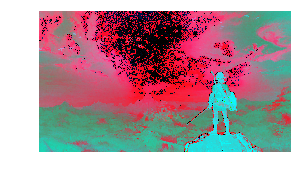

In [5]:
#So, if each pixel is a array of color values, we can "rotate" the color 
#To create an oddly colored image
def do_normalise(im):
    return -np.log(1/((1 + im)/257) - 1)
 
def undo_normalise(im):
    return (1 + 1/(np.exp(-im) + 1) * 257).astype("uint8")

def rotation_matrix(theta):
    """
    3D rotation matrix around the X-axis by angle theta
    """
    return np.c_[
        [1,0,0],
        [0,np.cos(theta),-np.sin(theta)],
        [0,np.sin(theta),np.cos(theta)]
    ]

im_normed = do_normalise(im)
im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(np.pi))
im2 = undo_normalise(im_rotated)

plti(im2)

In [8]:
#And this is a similar thing but animated. 
#Doesn't seem to be working but thats fine.
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(5,8))

def update(i):
    im_normed = do_normalise(im)
    im_rotated = np.einsum("ijk,lk->ijl", im_normed, rotation_matrix(i * np.pi/10))
    im2 = undo_normalise(im_rotated)
    
    ax.imshow(im2)
    ax.set_title("Angle: {}*pi/10".format(i), fontsize=20)
    ax.set_axis_off()


anim = FuncAnimation(fig, update, frames=np.arange(0, 20), interval=50)
anim.save('colour_rotation.gif', dpi=80, writer='imagemagick')
plt.close()

# <img src="colour_rotation.gif">

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


In [9]:
#Next two celss are converting to greyscale

def to_grayscale(im, weights = np.c_[0.2989, 0.5870, 0.1140]):
    """
    Transforms a colour image to a greyscale image by
    taking the mean of the RGB values, weighted
    by the matrix weights
    """
    tile = np.tile(weights, reps=(im.shape[0],im.shape[1],1))
    return np.sum(tile * im, axis=2)

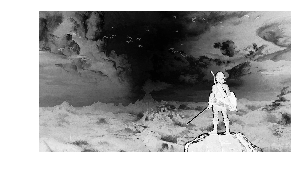

In [10]:
img = to_grayscale(im)

plti(img, cmap='Greys')

In [11]:
#This is a convolution, defined as 
#C(x,y)=∫dx′dy′I(x+x′,y+y′)W(x′,y′)
#Where C is the convulted image, I is the original image and
#W is a window function. We are replacing each pixel with a weighted 
#sum of nearby pixels. 
#Because they are expensive, we shrink the image.
from scipy.ndimage.interpolation import zoom
im_small = zoom(im, (0.2,0.2,1))

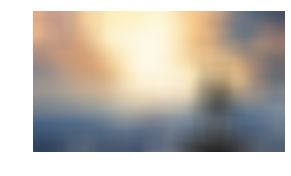

In [12]:
from scipy.signal import convolve2d

def convolve_all_colours(im, window):
    """
    Convolves im with window, over all three colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = convolve2d(im[:,:,d], window, mode="same", boundary="symm")
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

n=50
window = np.ones((n,n))
window /= np.sum(window)
plti(convolve_all_colours(im_small, window))

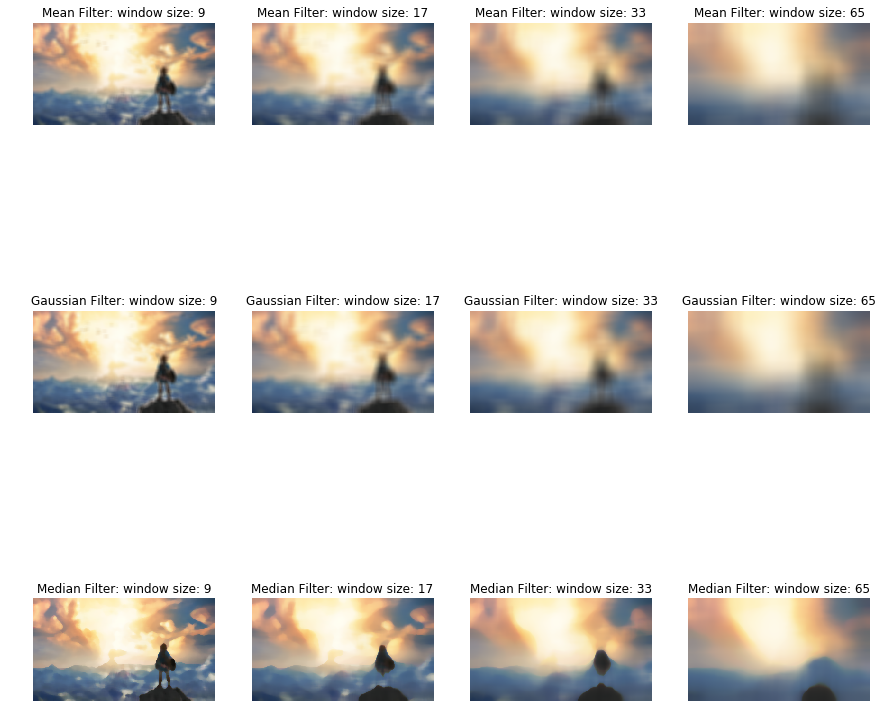

In [13]:
#Maybe a bit esoteric, but here are some other things you can do with 
#a convoluted image. 

from scipy.ndimage import median_filter

def make_gaussian_window(n, sigma=1):
    """
    Creates a square window of size n by n of weights from a gaussian
    of width sigma.
    """
    nn = int((n-1)/2)
    a = np.asarray([[x**2 + y**2 for x in range(-nn,nn+1)] for y in range(-nn,nn+1)])
    return np.exp(-a/(2*sigma**2))

def median_filter_all_colours(im_small, window_size):
    """
    Applies a median filer to all colour channels
    """
    ims = []
    for d in range(3):
        im_conv_d = median_filter(im_small[:,:,d], size=(window_size,window_size))
        ims.append(im_conv_d)

    im_conv = np.stack(ims, axis=2).astype("uint8")
    
    return im_conv

window_sizes = [9,17,33,65]
fig, axs = plt.subplots(nrows=3, ncols=len(window_sizes), figsize=(15,15));

# mean filter
for w, ax in zip(window_sizes, axs[0]):
    window = np.ones((w,w))
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Mean Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# gaussian filter
for w, ax in zip(window_sizes, axs[1]):
    window = make_gaussian_window(w,sigma=w)
    window /= np.sum(window)
    ax.imshow(convolve_all_colours(im_small, window));
    ax.set_title("Gaussian Filter: window size: {}".format(w));
    ax.set_axis_off();
    
# median filter
for w, ax in zip(window_sizes, axs[2]):
    ax.imshow(median_filter_all_colours(im_small, w));
    ax.set_title("Median Filter: window size: {}".format(w));
    ax.set_axis_off();

In [14]:
#
#
#Blurring is only one use of convolutions in image processing. By using more exotic windows, was can extract different kinds of information. The Sobel filter tried to approximate the gradients of the image along one direction using window functions of the form
#
#[[-1,0,1],
#[-2,0,2],
# [-1,0,1]]
#
#By finding the gradient in both the X and Y directions, and then taking the magnitude of these values we get a map of the gradients in an image for each colour

%%time

n=100
sobel_x = np.c_[
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
]

sobel_y = np.c_[
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
]

ims = []
for d in range(3):
    sx = convolve2d(im_small[:,:,d], sobel_x, mode="same", boundary="symm")
    sy = convolve2d(im_small[:,:,d], sobel_y, mode="same", boundary="symm")
    ims.append(np.sqrt(sx*sx + sy*sy))

im_conv = np.stack(ims, axis=2).astype("uint8")

plti(im_conv)

UsageError: Line magic function `%%time` not found.


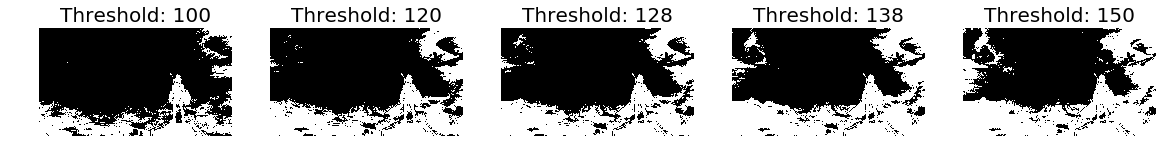

In [15]:
def simple_threshold(im, threshold=128):
    return ((im > threshold) * 255).astype("uint8")

thresholds = [100,120,128,138,150]

fig, axs = plt.subplots(nrows=1, ncols=len(thresholds), figsize=(20,5));
gray_im = to_grayscale(im)
                        
for t, ax in zip(thresholds, axs):
    ax.imshow(simple_threshold(gray_im, t), cmap='Greys');
    ax.set_title("Threshold: {}".format(t), fontsize=20);
    ax.set_axis_off();

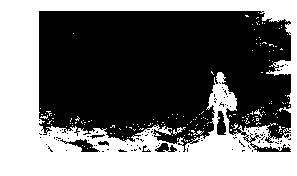

In [16]:
def otsu_threshold(im):

    pixel_counts = [np.sum(im == i) for i in range(256)]

    s_max = (0,-10)
    ss = []
    for threshold in range(256):

        # update
        w_0 = sum(pixel_counts[:threshold])
        w_1 = sum(pixel_counts[threshold:])

        mu_0 = sum([i * pixel_counts[i] for i in range(0,threshold)]) / w_0 if w_0 > 0 else 0       
        mu_1 = sum([i * pixel_counts[i] for i in range(threshold, 256)]) / w_1 if w_1 > 0 else 0

        # calculate 
        s = w_0 * w_1 * (mu_0 - mu_1) ** 2
        ss.append(s)

        if s > s_max[1]:
            s_max = (threshold, s)
            
    return s_max[0]

t = otsu_threshold(gray_im)
plti(simple_threshold(gray_im, t), cmap='Greys')

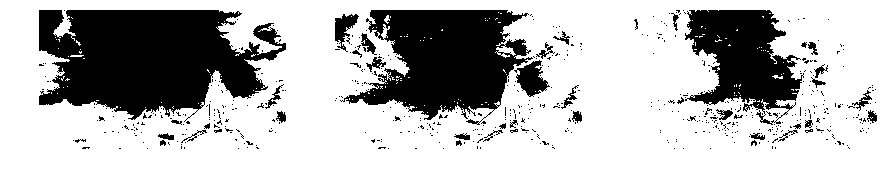

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

c_ims = []
for c, ax in zip(range(3), axs):
    tmp_im = im[:,:,c]
    t = otsu_threshold(tmp_im)
    tmp_im = simple_threshold(tmp_im, t)
    ax.imshow(tmp_im, cmap='Greys')
    c_ims.append(tmp_im)
    ax.set_axis_off()

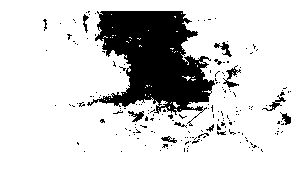

In [18]:
plti(c_ims[0] & c_ims[1] & c_ims[2], cmap='Greys')